In [ ]:
import re
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2
%matplotlib inline
# pip install "black[jupyter]"



In [ ]:
"/content/gdrive/MyDrive/score_png/negativo/460".split("/")[-1]

'460'

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
files = pd.read_csv("merged.csv", sep=";")
files["status_escore"] = files.apply(
    lambda x: 0 if x["score"] <= 300 else 1, axis=1
)  # negativo 0 e positivo 1
files["path"] = files["filepath"].str.split("_").str[1]
files["folder"] = files["filepath"].str.split("\\").str[1]


def criar_nova_coluna(row):
    if row["folder"] == "positivo":
        return "/content/gdrive/MyDrive/score_png/positivo/" + row["path"]
    else:
        return "/content/gdrive/MyDrive/score_png/negativo/" + row["path"]


# Aplicando a função a cada linha do DataFrame
files["filepath"] = files.apply(criar_nova_coluna, axis=1)

files.filepath = files.apply(
    lambda x: x["filepath"].replace(".dcm", "_{}.png".format(x["SeriesDescription"])),
    axis=1,
)
files = files[["filepath", "status_escore"]]

In [ ]:
files = files[
    files.filepath
    != "/content/gdrive/MyDrive/score_png/negativo/1060310389000200_PA.png"
]
files = files[
    files.filepath
    != "/content/gdrive/MyDrive/score_png/positivo/8200075835000100_PA.png"
]
files = files[
    files.filepath
    != "/content/gdrive/MyDrive/score_png/positivo/6600615683000200_PA.png"
]

In [ ]:
sample_size = 1320
files2 = pd.concat(
    [
        files[files["status_escore"] == 0].sample(1320, random_state=42),
        files[files["status_escore"] == 1],
    ]
)

# Reset the index of the resulting DataFrame if needed
files2.reset_index(drop=True, inplace=True)

In [ ]:
files2.status_escore.value_counts(normalize=False)

0    1320
1    1320
Name: status_escore, dtype: int64

In [ ]:
files["status_escore"].value_counts(normalize=False)

0    10659
1     1320
Name: status_escore, dtype: int64

In [ ]:
merged_df = files.merge(
    files2[["filepath"]], on="filepath", how="outer", indicator=True
)
non_matching_df = merged_df[merged_df["_merge"] == "left_only"]
print("classe 0", len(non_matching_df[non_matching_df["status_escore"] == 0]))
print("classe 1", len(non_matching_df[non_matching_df["status_escore"] == 1]))

classe 0 9339
classe 1 0


In [ ]:
strategy = tf.distribute.MirroredStrategy()  # for GPU or multi-GPU machines
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [ ]:
BATCH_SIZE = 16
IMG_WIDTH = 224
IMG_HEIGHT = 224

train_df, test_df = train_test_split(
    files2, train_size=0.9, shuffle=True, random_state=10
)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.1, horizontal_flip=True
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="status_escore",
    target_size=(IMG_WIDTH, IMG_WIDTH),
    color_mode="rgb",
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=10,
    subset="training",
    validate_filenames=False,
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="status_escore",
    target_size=(IMG_WIDTH, IMG_WIDTH),
    color_mode="rgb",
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=10,
    subset="validation",
    validate_filenames=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="status_escore",
    target_size=(IMG_WIDTH, IMG_WIDTH),
    color_mode="rgb",
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False,
    validate_filenames=False,
)

Found 2139 non-validated image filenames.
Found 237 non-validated image filenames.
Found 264 non-validated image filenames.


In [ ]:
def create_model(summary=True):
    # apply transfer learning
    # new_input = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    model = ResNet50(
        weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_WIDTH, 3)
    )
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    output = layers.Dense(1, activation="sigmoid")(flat1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    METRICS = [tf.keras.metrics.AUC(curve="ROC", name="ROC")]
    model.compile(
        optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=METRICS
    )
    # if summary:
    #   print(model.summary())
    return model


model_dir = "/content/gdrive/MyDrive/modelcam"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpoint_path = model_dir + "/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True, verbose=1
)

model = create_model()

history = model.fit(
    train_images, epochs=10, validation_data=val_images, callbacks=[cp_callback]
)

Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 1.2570 - ROC: 0.6176
Epoch 1: saving model to /content/gdrive/MyDrive/modelcam/cp.ckpt
134/134 [==============================] - 681s 5s/step - loss: 1.2570 - ROC: 0.6176 - val_loss: 1.7315 - val_ROC: 0.6149
Epoch 2/10
134/134 [==============================] - ETA: 0s - loss: 0.9750 - ROC: 0.7323
Epoch 2: saving model to /content/gdrive/MyDrive/modelcam/cp.ckpt
134/134 [==============================] - 326s 2s/step - loss: 0.9750 - ROC: 0.7323 - val_loss: 1.2001 - val_ROC: 0.6364
Epoch 3/10
134/134 [==============================] - ETA: 0s - loss: 0.7882 - ROC: 0.7936
Epoch 3: saving model to /content/gdrive/MyDrive/modelcam/cp.ckpt
134/134 [==============================] - 337s 3s/step - loss: 0.7882 - ROC: 0.7936 - val_loss: 1.5555 - val_ROC: 0.7459
Epoch 4/10
134/134 [==============================] - ETA: 0s - loss: 0.6368 - ROC: 0.8618
Epoch 4: saving model to /content/gdrive/MyDrive/modelcam/cp.ckpt
134/13

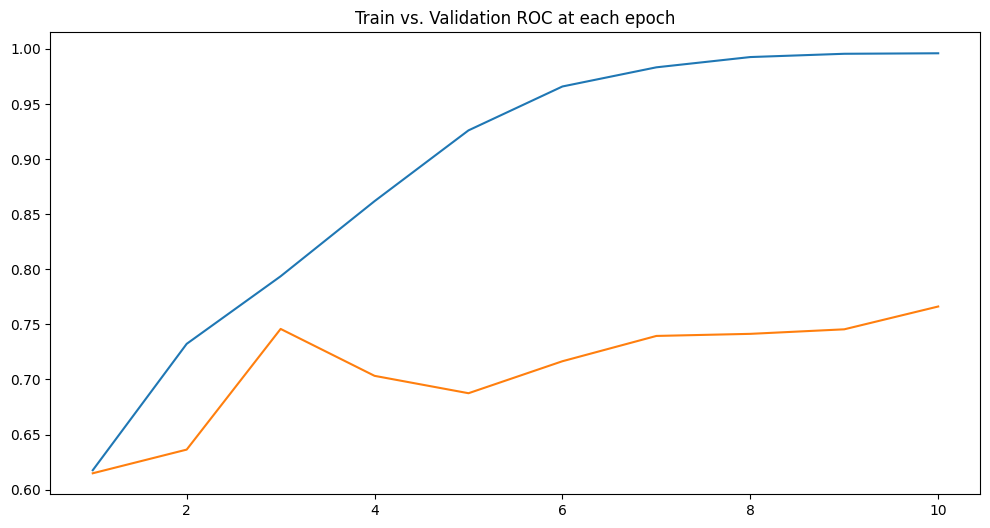

In [ ]:
# show history
history_df = pd.DataFrame(history.history)
epochs = list(range(1, 11))

plt.figure(figsize=(12, 6))
plt.plot(epochs, history_df["ROC"].values)
plt.plot(epochs, history_df["val_ROC"].values)
plt.title("Train vs. Validation ROC at each epoch")
plt.show()

In [ ]:
print(model.evaluate(test_images, return_dict=True))

17/17 [==============================] - 28s 2s/step - loss: 1.1335 - ROC: 0.6948
{'loss': 1.133499264717102, 'ROC': 0.6948320865631104}


17/17 [==============================] - 100s 6s/step


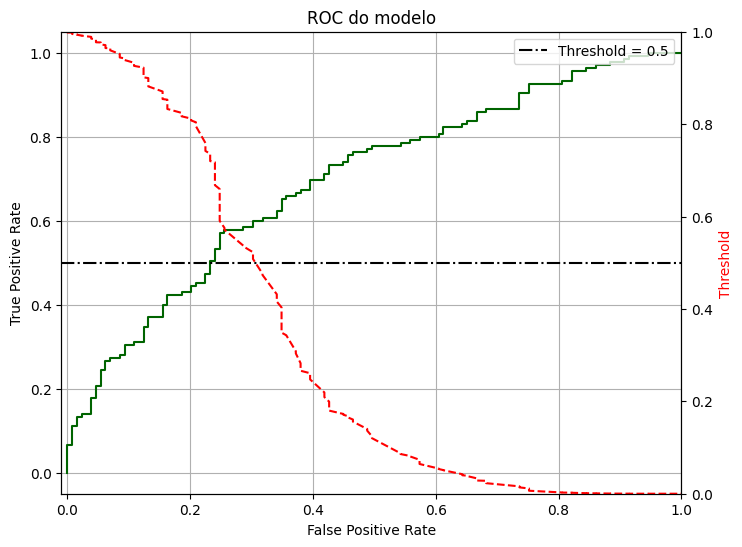

In [ ]:
# model.evaluate(test_images, return_dict=True)
y_pred = model.predict(test_images)
predicted_classes = [1 if y >= 0.5 else 0 for y in y_pred]
y_test = test_df.status_escore

fpr, tpr, sarrafo = roc_curve(y_test, y_pred)
sarrafo = sarrafo[fpr <= 1]
# create ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1.5, color="darkgreen")
plt.grid()
plt.title(f"ROC do modelo")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
ax2 = plt.gca().twinx()
ax2.plot(fpr, sarrafo, markeredgecolor="r", linestyle="dashed", color="r")
ax2.set_ylabel("Threshold", color="r")
ax2.set_ylim([0, 1])
ax2.set_xlim([-0.01, 1])
ax2.axhline(y=0.5, lw=1.5, color="black", ls="-.", label="Threshold = 0.5")
plt.legend()
plt.show()

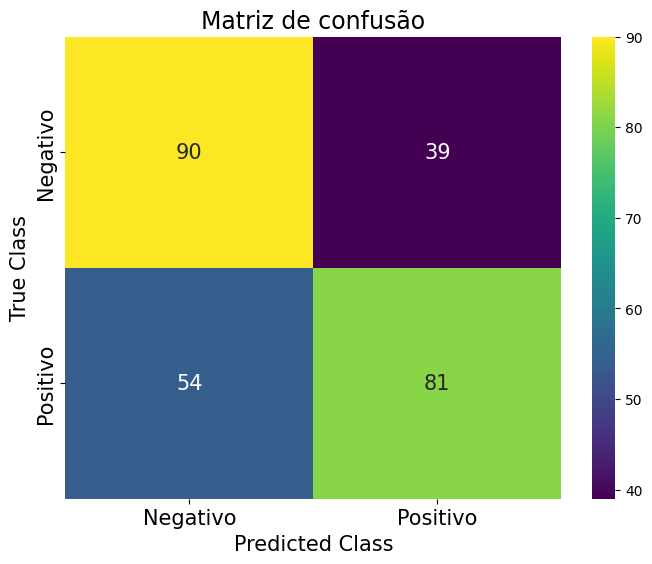

In [ ]:
plt.figure(figsize=(8, 6))
matriz = confusion_matrix(y_test, predicted_classes)
ax = sns.heatmap(
    matriz, cmap="viridis", annot=True, annot_kws={"fontsize": 15}, fmt="d"
)  # Use "d" for absolute values
ax.set_title("Matriz de confusão", fontsize=17)
ax.set_ylabel("True Class", fontsize=15)
ax.set_xlabel("Predicted Class", fontsize=15)
ax.set_xticklabels(["Negativo", "Positivo"], fontsize=15)
ax.set_yticklabels(["Negativo", "Positivo"], fontsize=15)
plt.show()

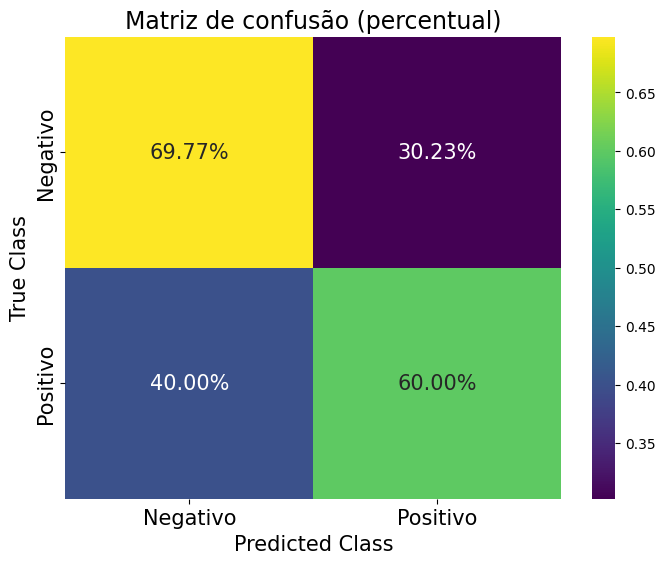

In [ ]:
plt.figure(figsize=(8, 6))
matriz = confusion_matrix(y_test, predicted_classes, normalize="true")
ax = sns.heatmap(
    matriz, cmap="viridis", annot=True, annot_kws={"fontsize": 15}, fmt=".2%"
)
ax.set_title(f"Matriz de confusão (percentual)", fontsize=17)
ax.set_ylabel("True Class", fontsize=15)
ax.set_xlabel("Predicted Class", fontsize=15)
ax.set_xticklabels(["Negativo", "Positivo"], fontsize=15)
ax.set_yticklabels(["Negativo", "Positivo"], fontsize=15)
plt.show()

ACTUAL LABEL: 1
1/1 [==============================] - 1s 1s/step
PRED LABEL: 0


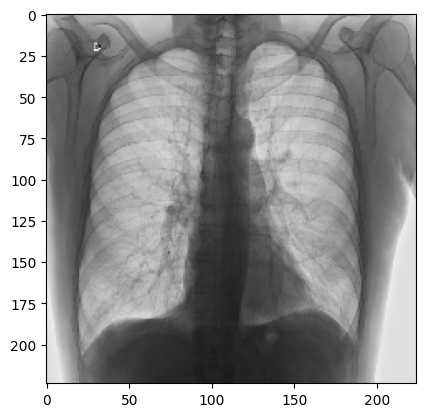

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
loaded_model = create_model(summary=True)
loaded_model.load_weights(latest)

img_paths = os.listdir("/content/gdrive/MyDrive/score_png/positivo/")
print("ACTUAL LABEL: 1")
folder_size = len(img_paths)
idx = np.random.randint(0, folder_size)
img = cv2.imread(
    "/content/gdrive/MyDrive/score_png/positivo/" + "/" + img_paths[idx],
)
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
rescaled_img = img / 255.0
plt.imshow(rescaled_img)
batch_pred = np.expand_dims(rescaled_img, 0)
pred = np.argmax(loaded_model.predict(batch_pred)[0])
if pred == 0:
    print("PRED LABEL: 0")
else:
    print("PRED LABEL: 1")

# The Grad-CAM algorithm

In [ ]:
test_df2 = test_df.reset_index(drop=True)
y_pred = model.predict(test_images)
predicted_classes = [1 if y >= 0.5 else 0 for y in y_pred]
test_df2["predict"] = predicted_classes

In [ ]:
test_df2.columns

Index(['filepath', 'status_escore', 'predict'], dtype='object')

In [ ]:
test_df2.head()

filepath  status_escore  predict
0  /content/gdrive/MyDrive/score_png/negativo/460...              0        1
1  /content/gdrive/MyDrive/score_png/positivo/700...              1        0
2  /content/gdrive/MyDrive/score_png/positivo/150...              0        0
3  /content/gdrive/MyDrive/score_png/positivo/100...              0        0
4  /content/gdrive/MyDrive/score_png/positivo/150...              1        1

In [ ]:
test_df2["filepath"][1]

'/content/gdrive/MyDrive/score_png/positivo/7000654541000100_PA.png'

In [ ]:
def show_img(img_array, title):
    plt.title(title)
    plt.imshow(img_array)
    plt.show()


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    model.layers[-1].activation = None
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    return superimposed_img  # show_img(superimposed_img, 'IMAGE OUT: Grad-CAM')


# make a prediction and visualize grad-cam
def make_prediction_and_visualize(
    test_df2, model, filepath_col, predict_col, target_col, last_conv_layer_name
):
    for i in range(len(test_df2)):
        img_path = test_df2[filepath_col][i]
        img = cv2.imread(img_path)
        img2 = img
        # show_img(img, 'IMAGE OUT: ACTUAL ')
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        rescaled_img = img / 255.0
        batch_pred = np.expand_dims(rescaled_img, 0)
        pred = np.argmax(model.predict(batch_pred)[0])

        heatmap = make_gradcam_heatmap(batch_pred, model, last_conv_layer_name)
        plot2 = save_and_display_gradcam(img_path, heatmap)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(img2)
        axes[0].set_title(f"ACTUAL LABEL: {test_df2[target_col][i]}")
        axes[1].imshow(plot2)
        axes[1].set_title(f"PRED LABEL: {test_df2[predict_col][i]}")
        plt.show()

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

1/1 [==============================] - 0s 74ms/step


<ipython-input-140-2a330c401684>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


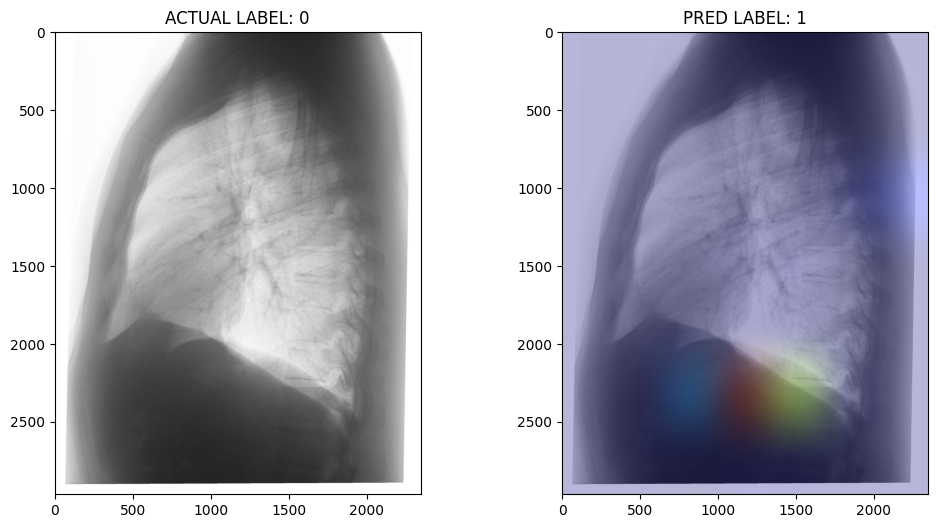

1/1 [==============================] - 0s 72ms/step


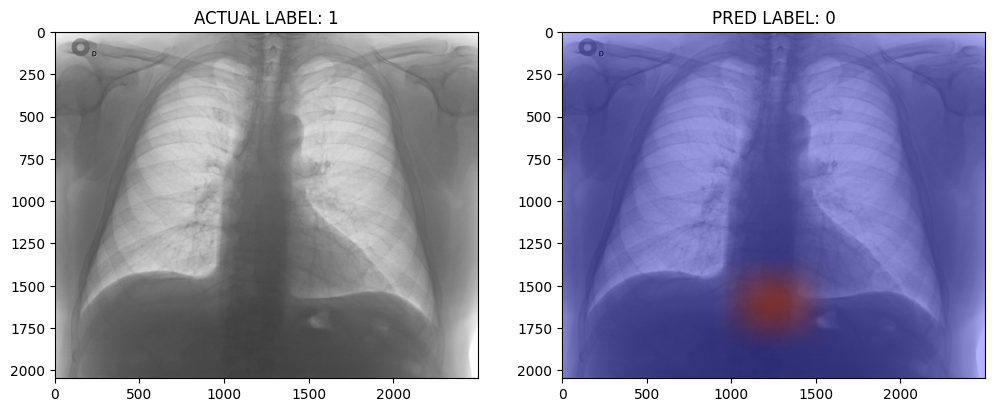

1/1 [==============================] - 0s 81ms/step


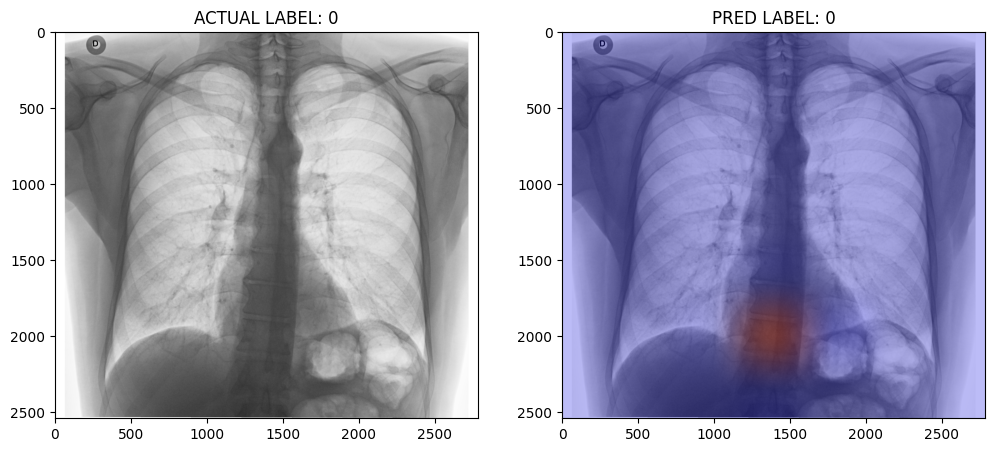

1/1 [==============================] - 0s 70ms/step


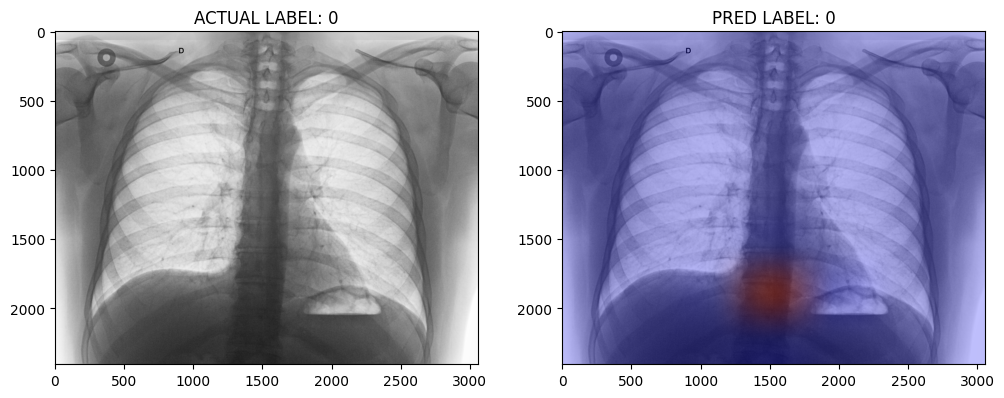

1/1 [==============================] - 0s 72ms/step


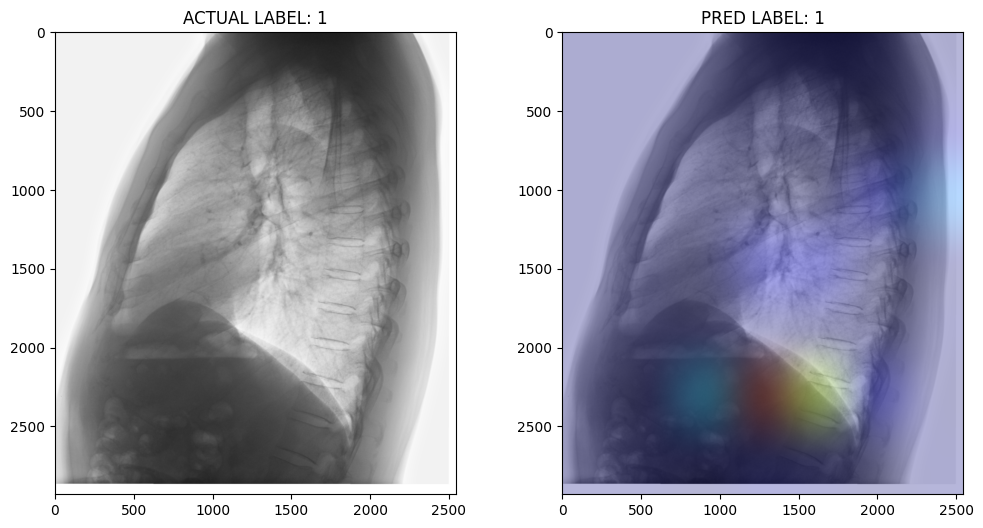

1/1 [==============================] - 0s 67ms/step


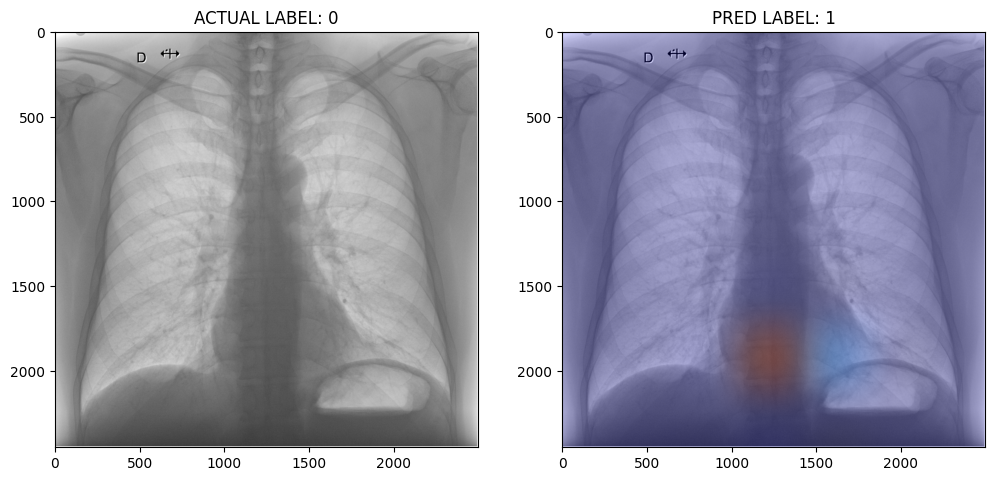

1/1 [==============================] - 0s 71ms/step


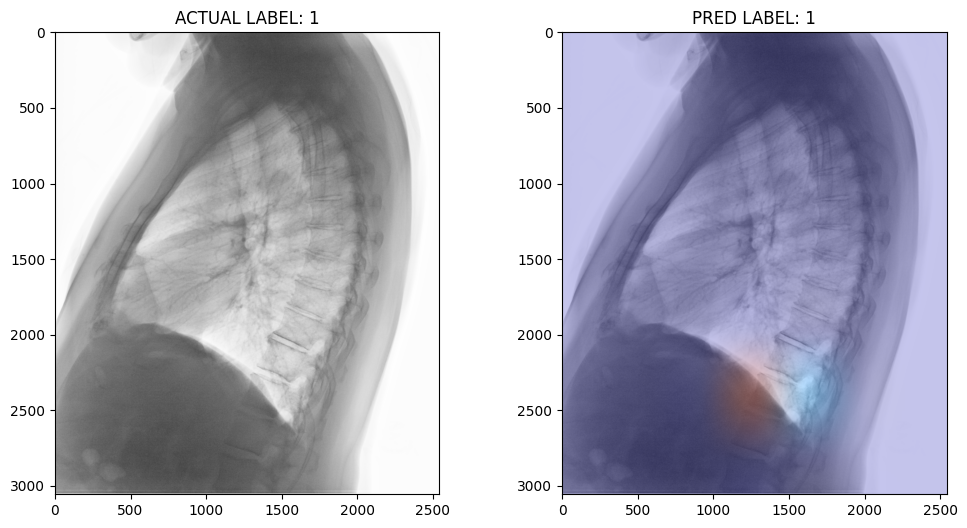

1/1 [==============================] - 0s 71ms/step


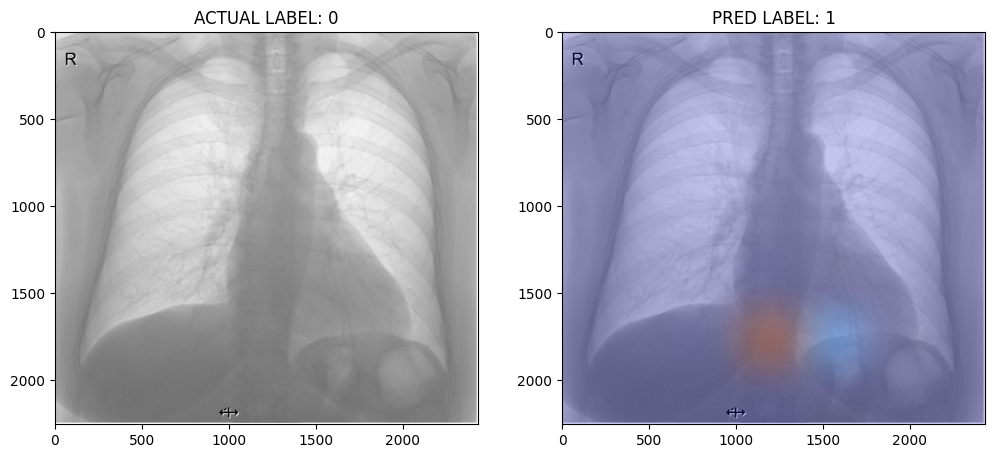

1/1 [==============================] - 0s 69ms/step


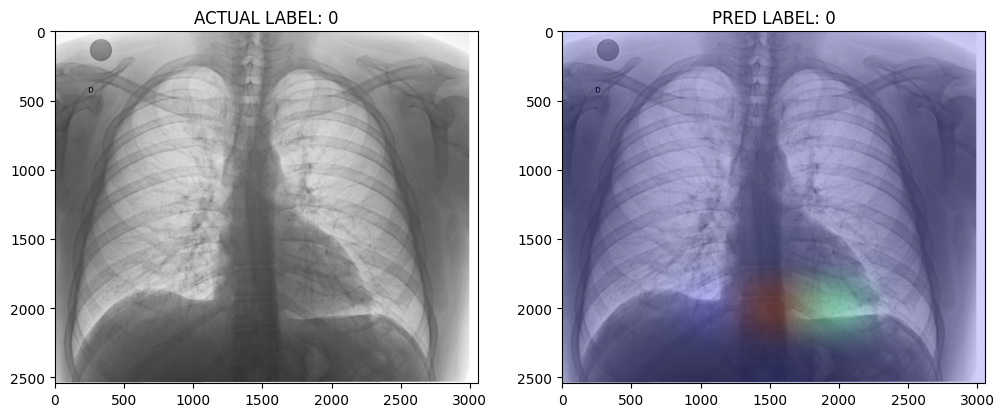

1/1 [==============================] - 0s 70ms/step


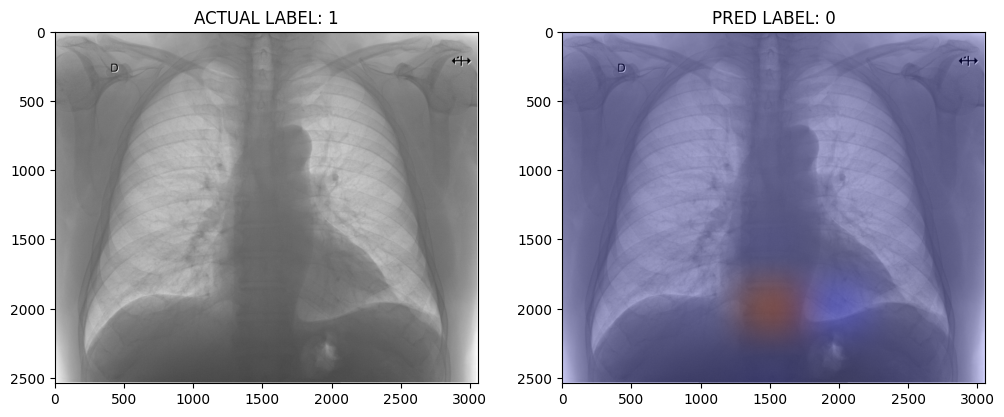

In [ ]:
make_prediction_and_visualize(
    test_df2=test_df2.head(10),
    model=model,
    filepath_col="filepath",
    predict_col="predict",
    target_col="status_escore",
    last_conv_layer_name="conv5_block3_3_conv",
)
# para saber o nome da last_conv_layer_name print o print(model.summary()) e pegue a última Conv2D: conv5_block3_3_conv (Conv2D)